# Transformer

## 输入部分

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import math
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import copy

### 词嵌入

In [7]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

### 位置编码器

In [3]:
class PositionalEncoding(nn.Module):
    # d_model是词嵌入维度
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(p=dropout)
        # 位置编码矩阵
        pe = torch.zeros(max_len, d_model)
        # 绝对位置矩阵
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2)*-(math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position*div_term)
        pe[:,1::2] = torch.cos(position*div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:,:x.size(1)],requires_grad=False)
        return self.dropout(x)


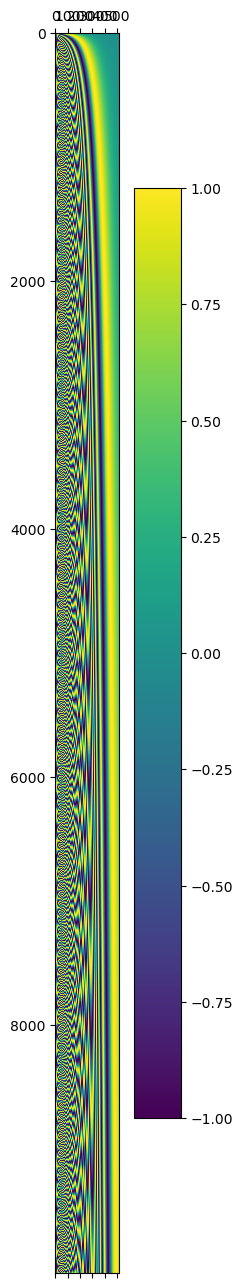

In [17]:
import numpy as np
import matplotlib.pyplot as plt
 
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P
 
P = getPositionEncoding(seq_len=10000, d=512, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

In [9]:
embeddings = Embeddings(512,1000)

In [5]:
x = torch.LongTensor([[1,2,3,4],[1,3,4,5]])

In [10]:
x = embeddings(x)

In [11]:
x.shape

torch.Size([2, 4, 512])

In [4]:
positionalEncoding = PositionalEncoding(512, 0.1)

In [12]:
pe_result = positionalEncoding(x)

In [14]:
pe_result

tensor([[[-13.2411,   8.1710,  37.9040,  ...,  21.8259,  33.5642, -33.9622],
         [ 11.6271,  28.8572,  -0.0000,  ...,  31.1791,  33.8334,   0.9991],
         [-30.6792,  -0.0000,  31.0784,  ...,  30.0349, -38.6880, -25.5244],
         [-30.6627,  19.8360, -30.7621,  ..., -31.8804, -13.8013,  20.2460]],

        [[-13.2411,   8.1710,  37.9040,  ...,  21.8259,  33.5642, -33.9622],
         [-30.7545, -26.1910,  30.9511,  ...,  30.0349, -38.6881, -25.5244],
         [-29.8091,  20.4736, -29.9939,  ..., -31.8804, -13.8014,  20.2460],
         [ -0.0000,   0.0000,  23.0451,  ...,  -4.3077,  -0.0000,   2.8341]]],
       grad_fn=<MulBackward0>)

In [13]:
pe_result.shape

torch.Size([2, 4, 512])

In [ ]:
plt.figure(figsize=(15,5))
pe = PositionalEncoding(20,0)
y = pe(Variable(torch.zeros(1,100,20)))
plt.plot(np.arange(100),y[0,:,4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

## 编码器

### 掩码张量

In [ ]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape),k=1).astype('uint8')
    return torch.from_numpy(1 - subsequent_mask)

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

### 注意力机制

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    # 先取词嵌入维度
    d_k = query.size(-1)
    # 把key的最后两个维度进行转置，q和k的维度是(batch, sequence_length_q, features)和(batch, sequence_length_k, features)
    # 因此torch.matmul(query, key.transpose(-2, -1))的维度是(batch, sequence_length_q, sequence_length_k)
    scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(d_k)
    print("attention", mask.shape, scores.shape)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    # 对最后一维做softmax操作
    p_attn = F.softmax(scores, dim = -1)

    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [ ]:
x = Variable(torch.randn(5,5))
x

In [ ]:
mask = Variable(torch.zeros(5,5))
mask

In [ ]:
y = x.masked_fill(mask == 0, -1e9)
y

In [ ]:
query = key = value = pe_result
mask = Variable(torch.zeros(2,4,4))
attn, p_attn = attention(query, key, value,mask=mask)
print('attn', attn)
print(attn.shape)
print('p_attn', p_attn)
print(p_attn.shape)

In [ ]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, head, embedding_dim, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert embedding_dim % head == 0
        self.d_k = embedding_dim // head
        self.head = head
        # 多头注意力中Q, K, V需要线性层，最后多头合并后还需要线性层，因此一共需要4个线性层
        self.linears = clones(nn.Linear(embedding_dim, embedding_dim), 4)
        # 代码最后得到的注意力张量
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # 使用squeeze将掩码张量进行维度扩充，代表多头中的第n个头
            mask = mask.unsqueeze(1)
        batch_size = query.size(0)
        # 这个地方非常重要，self.linears中的前三个矩阵就是q,k,v的权重矩阵，是被用来迭代训练的
        query, key, value = [model(x).view(batch_size, -1, self.head, self.d_k).transpose(1,2) for model, x in zip(self.linears, (query,key,value))]
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        x = x.transpose(1,2).contiguous().view(batch_size, -1, self.head*self.d_k)
        return self.linears[-1](x)

In [ ]:
head = 8
embedding_dim = 512
dropout = 0.2

query = key = value = pe_result
mask = Variable(torch.zeros(2,4,4))
mha = MultiHeadedAttention(head, embedding_dim, dropout)
mha_result = mha(query, key, value, mask)
print(mha_result)
print(mha_result.shape)

### 前馈全连接层

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w2(self.dropout(F.relu(self.w1(x))))

In [ ]:
d_model = 512
d_ff = 64
dropout = 0.2

x = mha_result
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
ff_result = ff(x)
print(ff_result)
print(ff_result.shape)

### 规范化层

In [ ]:
class LayerNorm(nn.Module):
    # eps在规范化公式中作为分母出现，为防止分母是0，设置为1e-6
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a2 = nn.Parameter(torch.ones(features))
        self.b2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        # keepdim操作让张量只在数字上进行规范化，而不会改变形状
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a2 * (x - mean) / (std + self.eps) + self.b2

In [ ]:
x = ff_result
ln = LayerNorm(512)
ln_result = ln(x)
print(ln_result)
print(ln_result.shape)

### 子层连接结构

In [ ]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout=0.1):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, sublayer):
        # sublayer是子层连接的函数
        return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
size = 512
dropout = 0.2
head = 8
d_model = 512

x = pe_result
mask = Variable(torch.zeros(2,4,4))
self_attn = MultiHeadedAttention(head, d_model)
sublayer = lambda x: self_attn(x,x,x,mask)

In [ ]:
sc = SublayerConnection(size, dropout)
sc_result = sc(x, sublayer)
print(sc_result)
print(sc_result.shape)

### 编码器层

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()

        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x,x,x,mask))
        return self.sublayer[1](x, self.feed_forward)


In [ ]:
size = 512
dropout = 0.2
head = 8
d_model = 512
d_ff = 64
x = pe_result

self_attn = MultiHeadedAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
mask = Variable(torch.zeros(2,4,4))

In [ ]:
el = EncoderLayer(size, self_attn, ff, dropout)
el_result = el(x, mask)
print(el_result)
print(el_result.shape)

### 编码器

In [ ]:
class Encoder(nn.Module):
    def __init__(self, layer, N) -> None:
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [ ]:
size = 512
dropout = 0.2
head = 8
d_model = 512
d_ff = 64
x = pe_result

c = copy.deepcopy

attn = MultiHeadedAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
layer = EncoderLayer(size, c(attn), c(ff), dropout)

N = 8
mask = Variable(torch.zeros(2,4,4))

In [ ]:
en = Encoder(layer, N)
en_result = en(x, mask)
print(en_result)
print(en_result.shape)

## 解码器

### 解码器层

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        # 多头自注意力对象，Q=K=V
        self.self_attn = self_attn
        # 这里Q!=K=V
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.dropout = dropout
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
    
    def forward(self, x, memory, source_mask, target_mask):
        # memory是编码器层的语义存储变量，source_mask是源数据掩码张量，
        # target_mask是目标数据掩码张量
        m = memory
        # 为了将解码时，未来的信息进行遮掩，采用target_mask,比如解码时解码到第二个字符，就只能看到第一个字符的信息
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, target_mask))

        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, source_mask))

        return self.sublayer[2](x, self.feed_forward)

In [ ]:
size = 512
dropout = 0.2
head = 8
d_model = 512
d_ff = 64
self_attn = src_attn = MultiHeadedAttention(head, d_model, dropout)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)

In [ ]:
x = pe_result
memory = en_result
mask = Variable(torch.zeros(2, 4, 4))
source_mask = target_mask = mask

In [ ]:
dl = DecoderLayer(size, self_attn, src_attn, ff, dropout)
dl_result = dl(x, memory, source_mask, target_mask)
print(dl_result)
print(dl_result.shape)

### 解码器

In [ ]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, source_mask, target_mask):
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        return self.norm(x)

In [ ]:
size = 512
dropout = 0.2
head = 8
d_model = 512
d_ff = 64
c = copy.deepcopy
attn = MultiHeadedAttention(head, d_model)
ff = PositionwiseFeedForward(d_model, d_ff, dropout)
layer = DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout)
N = 8

In [ ]:
x = pe_result
memory = en_result
mask = Variable(torch.zeros(2, 4, 4))
source_mask = target_mask = mask

In [ ]:
de = Decoder(layer, N)
de_result = de(x, memory, source_mask, target_mask)
print(de_result)
print(de_result.shape)

## 输出部分

In [ ]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(Generator, self).__init__()
        self.project = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        # 对最后一个维度，也就是vocab_size取softmax
        return F.log_softmax(self.project(x), dim=-1)

In [ ]:
d_model = 512
vocab_size = 1000

In [ ]:
gen = Generator(d_model, vocab_size)
gen_result = gen(x)
print(gen_result)
print(gen_result.shape)

## 模型的构建

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, source_embed, target_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = source_embed
        self.tgt_embed = target_embed
        self.generator = generator

    def encode(self, source, source_mask):
        return self.encoder(self.src_embed(source), source_mask)
    
    def decode(self, memory, source_mask, target, target_mask):
        return self.decoder(self.tgt_embed(target), memory, source_mask, target_mask)

    def forward(self, source, target, source_mask, target_mask):
        return self.decode(self.encode(source, source_mask), source_mask, target, target_mask)

In [ ]:
vocab_size = 1000
d_model = 512
encoder = en
decoder = de
source_embed = nn.Embedding(vocab_size, d_model)
target_embed = nn.Embedding(vocab_size, d_model)
generator = gen

In [ ]:
# 假设源数据与目标数据相同, 实际中并不相同
source = target = Variable(torch.LongTensor([[100, 2, 421, 508], [491, 998, 1, 221]]))

# 假设src_mask与tgt_mask相同，实际中并不相同
source_mask = target_mask = Variable(torch.zeros(2, 4, 4))

In [ ]:
ed = EncoderDecoder(encoder, decoder, source_embed, target_embed, generator)
ed_result = ed(source, target, source_mask, target_mask)
print(ed_result)
print(ed_result.shape)

In [ ]:
def make_model(source_vocab, target_vocab, N=6, d_model=512, d_ff=2048, head=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadedAttention(head, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, source_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, target_vocab), c(position)),
        Generator(d_model, target_vocab)
    )
    # 模型结构完成后，接下来就是初始化模型中的参数，比如线性层中的变换矩阵
    # 这里一但判断参数的维度大于1，则会将其初始化成一个服从均匀分布的矩阵U(-a, a)，
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [ ]:
source_vocab = 11
target_vocab = 11 
N = 6

In [ ]:
if __name__ == '__main__':
    res = make_model(source_vocab, target_vocab, N)
    print(res)

## 使用copy任务进行模型基本测试的四步曲

In [ ]:
# 导入工具包Batch, 它能够对原始样本数据生成对应批次的掩码张量
from pyitcast.transformer_utils import Batch  

def data_generator(V, batch, num_batch):
    """
        该函数用于随机生成copy任务的数据, 它的三个输入参数是V: 随机生成数字的最大值+1, 
        batch: 每次输送给模型更新一次参数的数据量, num_batch: 一共输送num_batch次完成一轮
    """
    # 使用for循环遍历nbatches
    for i in range(num_batch):
        # 在循环中使用np的random.randint方法随机生成[1, V)的整数, 
        # 分布在(batch, 10)形状的矩阵中, 然后再把numpy形式转换称torch中的tensor.
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))

        # 接着使数据矩阵中的第一列数字都为1, 这一列也就成为了起始标志列, 
        # 当解码器进行第一次解码的时候, 会使用起始标志列作为输入.
        data[:, 0] = 1

        # 因为是copy任务, 所有source与target是完全相同的, 且数据样本作用变量不需要求梯度
        # 因此requires_grad设置为False
        source = Variable(data, requires_grad=False)
        target = Variable(data, requires_grad=False)

        # 使用Batch对source和target进行对应批次的掩码张量生成, 最后使用yield返回
        yield Batch(source, target) 

In [ ]:
# 将生成0-10的整数
V = 11

# 每次喂给模型20个数据进行参数更新
batch = 20 

# 连续喂30次完成全部数据的遍历, 也就是1轮
num_batch = 30

In [ ]:
if __name__ == '__main__':
    res = data_generator(V, batch, num_batch)
    print(res)

### 获得Transformer模型及其优化器和损失函数

In [ ]:
class SimpleLossCompute:
    """A simple loss compute and train function."""
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1))
        loss = loss / norm
        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm  # 修改这里，使用 .item() 获取0维张量的Python数值


In [ ]:
from pyitcast.transformer_utils import get_std_opt
from pyitcast.transformer_utils import LabelSmoothing

model = make_model(V, V, N=2)
model_optimizer = get_std_opt(model)
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
loss = SimpleLossCompute(model.generator, criterion, model_optimizer)


In [ ]:
from pyitcast.transformer_utils import LabelSmoothing

# 使用LabelSmoothing实例化一个crit对象.
# 第一个参数size代表目标数据的词汇总数, 也是模型最后一层得到张量的最后一维大小
# 这里是5说明目标词汇总数是5个. 第二个参数padding_idx表示要将那些tensor中的数字
# 替换成0, 一般padding_idx=0表示不进行替换. 第三个参数smoothing, 表示标签的平滑程度
# 如原来标签的表示值为1, 则平滑后它的值域变为[1-smoothing, 1+smoothing].
crit = LabelSmoothing(size=5, padding_idx=0, smoothing=0.5)

# 假定一个任意的模型最后输出预测结果和真实结果
predict = Variable(torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]]))

# 标签的表示值是0，1，2
target = Variable(torch.LongTensor([2, 1, 0]))

# 将predict, target传入到对象中
crit(predict, target)

# 绘制标签平滑图像
plt.imshow(crit.true_dist)

### 运行模型进行训练评估

In [ ]:
from pyitcast.transformer_utils import run_epoch

def run(model, loss, epochs=10):
    # 遍历轮数
    for epoch in range(epochs):
        # 模型使用训练模式, 所有参数将被更新
        model.train()
        # 训练时, batch_size是20
        run_epoch(data_generator(V, 8, 20), model, loss)

        # 模型使用评估模式, 参数将不会变化 
        model.eval()
        # 评估时, batch_size是5
        run_epoch(data_generator(V, 8, 5), model, loss)

In [ ]:
run(model, loss)

In [ ]:
from pyitcast.transformer_utils import greedy_decode 


def run(model, loss, epochs=1):
    for epoch in range(epochs):
        model.train()

        run_epoch(data_generator(V, 8, 20), model, loss)

        model.eval()

        run_epoch(data_generator(V, 8, 5), model, loss)

    # 模型进入测试模式
    model.eval()

    # 假定的输入张量
    source = Variable(torch.LongTensor([[1,3,2,5,4,6,7,8,9,10]]))

    # 定义源数据掩码张量, 因为元素都是1, 在我们这里1代表不遮掩
    # 因此相当于对源数据没有任何遮掩.
    source_mask = Variable(torch.ones(1, 1, 10))

    # 最后将model, src, src_mask, 解码的最大长度限制max_len, 默认为10
    # 以及起始标志数字, 默认为1, 我们这里使用的也是1
    result = greedy_decode(model, source, source_mask, max_len=10, start_symbol=1)
    print(result)

In [ ]:
run(model, loss)
